# <u>Introduction</u>

<u>Name:</u> Sophia Smola Matsui

This project sets out to analyze riding patterns of bike-share users and train a classification model that can predict whether a cyclist is a member or
casual rider, based on their ride statistics from the data. In class, we have learned various classification algorithms, and it could be benificial for the Chicago-based bike-share company called Divvy, when they want to predict trends between casual and member customers. 

My motivaton for this project comes from my passion for cycling, and curiosity on people in Chicago, where the majority of data is most likely from. (I used to live in Pennsylvania, and feel some connection to Chicago as it was nearby.) Furthermore, I am curious about how members(athletes) differ in terms of habits, compared to the average person (casual rider).

The type of data necessary for this, was data that contained details about bike usage, between member and casual riders.

# <u>Background</u>

The data of this project is obtainted from kaggle:

[https://www.kaggle.com/datasets/gerardcebolla/cyclistic-12-csv/data](https://www.kaggle.com/datasets/gerardcebolla/cyclistic-12-csv/data)

data is originally from: 
[https://divvy-tripdata.s3.amazonaws.com/index.html](https://divvy-tripdata.s3.amazonaws.com/index.html), however it is only from 2023-2024 and preprocessed quite a bit before being put into kaggle.


<b> The data set also comes with the following explanation for each data column: </b> 

month: The month and year when each ride took place, allowing for time-based analysis of ride trends.

member_casual: Indicates whether the rider was a member (subscription holder) or a casual rider (pay-per-ride).

rideable_type: The type of bike used for the ride, such as "classic" or "electric."

day_type: Categorizes the ride as occurring on a weekday or weekend.

day_of_week: The specific day of the week the ride occurred, useful for identifying weekly ride patterns.

time_of_day: The time period during which the ride occurred, split into seven segments to capture different times of the day.

length_distro_min: The total duration of the ride, measured in minutes, split into seven segments to represent different ranges of ride lengths.

ride_count: The total number of rides within each specified aggregation (e.g., by month, user type).

sum_ride_length_sec: The total duration of the ride, measured in seconds, reflecting how long the ride lasted.

# <u>Analysis</u>

## <u>Data Inspection and Cleaning</u> 

### <u>Data Inspection </u> 

The first step that is necessary in any kind of data analysis, is data cleaning. Data often does not come pre-processed, or often the data types are not optimal for making models. There are many issues that could be within the data, such as a large amount of Nan values, or information that is not quite relevant. 

For example while this dataset comes with 9 features, some of them might not provide important additional information.

In [1]:
#import modules for analysis + preparing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Therefore, we first check the shape/size of the data to make sure it is in the appropiate range.

In [2]:
#read data from csv file
cyclistdata = pd.read_csv("cyclistic_12.csv")

#show shape of data
print("number of rows: ", cyclistdata.shape[0])
print("number of columns: ", cyclistdata.shape[1])

number of rows:  16464
number of columns:  9


Sence we want to classify between member and casual users, we want to see how evenly the data is distributed between our member and casual counts, to prevent biased answers, or see how skewed data may be. 

In [3]:
counts = cyclistdata.member_casual.value_counts()
print(f"member: {counts.get('member', 0)}")
print(f"casual: {counts.get('casual', 0)}")

member: 8232
casual: 8232


We see that there are an equal number of member and casual users. This indicates that there may have been stratified sampling, at least for member vs casual.

Next, we will display the first 5 rows of the df, to get a better idea of the data.

In [4]:
print("\nFirst 5 rows of the DataFrame:")
cyclistdata.head()


First 5 rows of the DataFrame:


,month,member_casual,rideable_type,day_type,day_of_week,time_of_day,length_distro_min,ride_count,sum_ride_length_sec
0,September 2024,casual,classic_bike,weekend,1,3:00 PM - 4:59 PM,60+,490,3964821
1,September 2024,casual,electric_bike,weekend,1,12:00 PM - 2:59 PM,31 - 40,156,332731
2,September 2024,casual,classic_bike,weekend,1,12:00 PM - 2:59 PM,60+,831,5495312
3,September 2024,casual,electric_bike,weekend,1,12:00 PM - 2:59 PM,51 - 60,75,251960
4,September 2024,casual,electric_bike,weekend,1,9:00 AM - 11:59 AM,31 - 40,139,301329


Just at first glance, we can assume that the data is sorted, by month, day of week and member type. 

We can also see that some columns may be containing redundant information (day_of_week/day_type) and (length_distro_min/sum_ride_length_sec)

We will look at the values associated with each column, to see which columns may be redundant.

In [5]:
columns = ['day_of_week', 'day_type', 'length_distro_min', 'sum_ride_length_sec']

for col in columns:
    print(f"\nColumn: {col}")
    print(cyclistdata[col].unique())


Column: day_of_week
[1 2 3 4 5 6 7]

Column: day_type
['weekend' 'weekday']

Column: length_distro_min
['60+' '31 - 40' '51 - 60' '0 - 10' '21 - 30' '11 - 20' '41 - 50']

Column: sum_ride_length_sec
[3964821  332731 5495312 ...   83531  330181  149690]


The day of the week column provides more useful information than the day_type column. While day_type only distinguishes between weekdays (1–5) and weekends (6–7), day of the week identifies each day separately. The weekday vs. weekend distinction is still carries valuable information for modeling, so we will keep the day_type column as well.

For length duration, both minutes and seconds contain the same information, but seconds offer more precision. Since the minutes column does not add any extra value, we will drop length_distro_min and keep the seconds column instead.

However, before we alter the df just yet, we will also check the and nans in case.

In [6]:
print(cyclistdata.isna().sum())

month                  0
member_casual          0
rideable_type          0
day_type               0
day_of_week            0
time_of_day            0
length_distro_min      0
ride_count             0
sum_ride_length_sec    0
dtype: int64


### <u>Data cleansing </u>

Now that we have a general idea of how the data is formatted we can start editing it, dropping columns and encoding values.

In [7]:
#dropping column
cyclistdata = cyclistdata.drop(['length_distro_min'], axis=1)

we will also rename columns, such that they are easier to interpret.

In [8]:
cyclistdata = cyclistdata.rename(columns={
    'member_casual': 'membership',
    'rideable_type': 'bike',
    'day_of_week': 'day',
    'time_of_day': 'time',
    'ride_count': 'frequency',
    'sum_ride_length_sec': 'length'
})

#check to see if properly updated
cyclistdata.head()

,month,membership,bike,day_type,day,time,frequency,length
0,September 2024,casual,classic_bike,weekend,1,3:00 PM - 4:59 PM,490,3964821
1,September 2024,casual,electric_bike,weekend,1,12:00 PM - 2:59 PM,156,332731
2,September 2024,casual,classic_bike,weekend,1,12:00 PM - 2:59 PM,831,5495312
3,September 2024,casual,electric_bike,weekend,1,12:00 PM - 2:59 PM,75,251960
4,September 2024,casual,electric_bike,weekend,1,9:00 AM - 11:59 AM,139,301329


We print the unique values in each column, for better label encoding.

In [9]:
for column in cyclistdata.columns:
    print(f"Unique values in '{column}': {cyclistdata[column].unique()}")

Unique values in 'month': ['September 2024' 'October 2024' 'August 2024' 'June 2024' 'May 2024'
 'March 2024' 'January 2024' 'July 2024' 'February 2024' 'April 2024'
 'November 2023' 'December 2023']
Unique values in 'membership': ['casual' 'member']
Unique values in 'bike': ['classic_bike' 'electric_bike']
Unique values in 'day_type': ['weekend' 'weekday']
Unique values in 'day': [1 2 3 4 5 6 7]
Unique values in 'time': ['3:00 PM - 4:59 PM' '12:00 PM - 2:59 PM' '9:00 AM - 11:59 AM'
 '12:00 AM - 5:59 AM' '8:00 PM - 11:59 PM' '5:00 PM - 7:59 PM'
 '6:00 AM - 8:59 AM']
Unique values in 'frequency': [ 490  156  831 ... 1011 2872 2749]
Unique values in 'length': [3964821  332731 5495312 ...   83531  330181  149690]


Now that we know the different values each column contains, we lable encode, to help make plotting distribution easier. 

(We change the values in each collumn into numerical values, such that we can make a model + plot to see distribution.)

In [10]:
cyclistdata = cyclistdata.reindex(columns=['month', 'bike',  'day_type', 'day', 'time', 'frequency', 'length', 'membership'])
cyclistdata['month'] = pd.to_datetime(cyclistdata['month'], format='%B %Y').dt.month
cyclistdata['bike'] = cyclistdata['bike'].map({'classic_bike': 0, 'electric_bike': 1})
cyclistdata['day_type'] = cyclistdata['day_type'].map({'weekend': 0, 'weekday': 1})
#no need encode membership because its the value that we are predicting.

time_mapping = {
    '12:00 AM - 5:59 AM': 3,
    '6:00 AM - 8:59 AM': 7.5,
    '9:00 AM - 11:59 AM': 10.5,
    '12:00 PM - 2:59 PM': 13.5,
    '3:00 PM - 4:59 PM': 16,
    '5:00 PM - 7:59 PM': 18.5,
    '8:00 PM - 11:59 PM': 22
}

cyclistdata['time'] = cyclistdata['time'].map(time_mapping)


We can double check that the df was properly updated, by looking at the dtypes of its columns.

In [11]:
display(cyclistdata.dtypes) #print the df types to double check that it is updated

month           int32
bike            int64
day_type        int64
day             int64
time          float64
frequency       int64
length          int64
membership     object
dtype: object

Next, we can use seaborn to pairplot all of the data. This can help us find trends, and correlation.

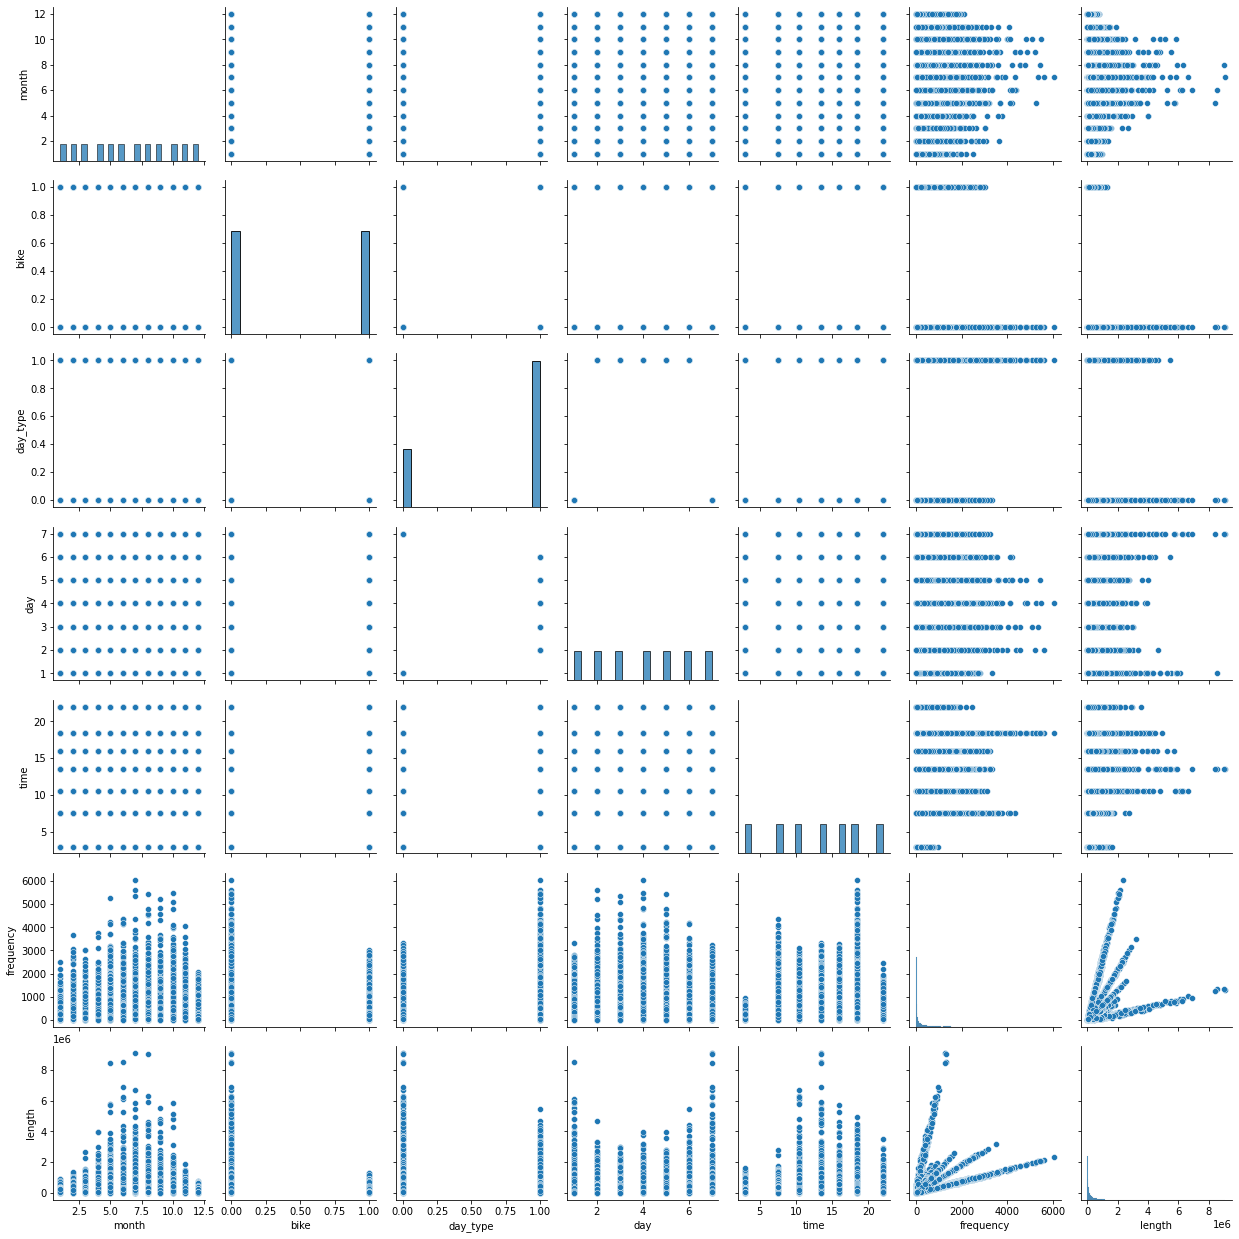

In [12]:
sns.pairplot(cyclistdata)

<u>Analysis from pairplots: </u>

When we look at the diagonal row and the distribution of several features (histograms), it is obvious that there was very heavy pre-processing done on this, and there is stratified sampling done for not only member/casual, but every feature other than frequency and length. 

Looking at the month vs length/frequency, we can see that it peaks/goes up around the summer, and goes down near winter. This allows us to see that people ride the bike more often in warmer seasons. 

Looking at bike type, we can see that people who use the classic bike ride more frequently, and for longer periods.

Looking at day type, we can see that people ride for longer periods on weekends, but more often on weekdays. 
This trend can also be seen in day vs length. We can see that people go on longer rides on weekends, most likely as people have more time, and use bike for leasure. However, the frequency goes down on weekends, most likely as people more often use bike for commuting on weekdays.

Looking at time, we see that people bike more frequently near 8am and pm, most likely for commuting to work. For length however, people ride for longer periods during the middle of the day, most likely due to the fact that people are riding for different purposes, such as exercise or are an athelete, and they can afford this. 

Looking at the length vs frequency, we notice some rays coming from the origin, which may indicate some trends. However, given that it is in a line, this is very unnatural, as usually it would be more scattered. Nonetheless, this does indicate that frequent riders go on for longer bike rides. 

The concentration of both length and frequency allow us to see that most people ride for short periods, is low frequency.

Next, we will try making another pairplot, but split it between casual and member riders. Furthermore, we will only have the frequency and length rows, as the remaining do not seem to exhibit any trends. 

In [13]:
# making df for casual and member
df1 = cyclistdata[cyclistdata['membership'] == 'casual'].copy()
df2 = cyclistdata[cyclistdata['membership'] == 'member'].copy()

Casual cyclist plots: 


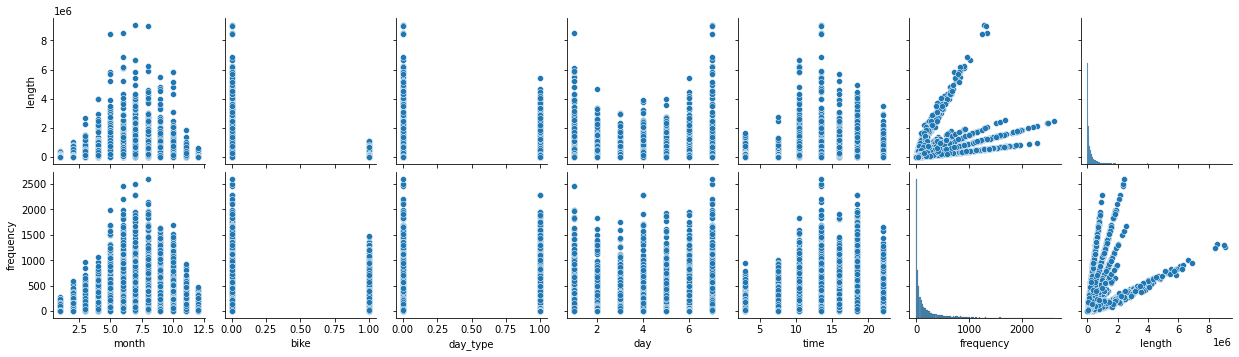

In [14]:
print("Casual cyclist plots: ")
sns.pairplot(df1, y_vars = ['length', 'frequency'])

Member cyclist plots: 


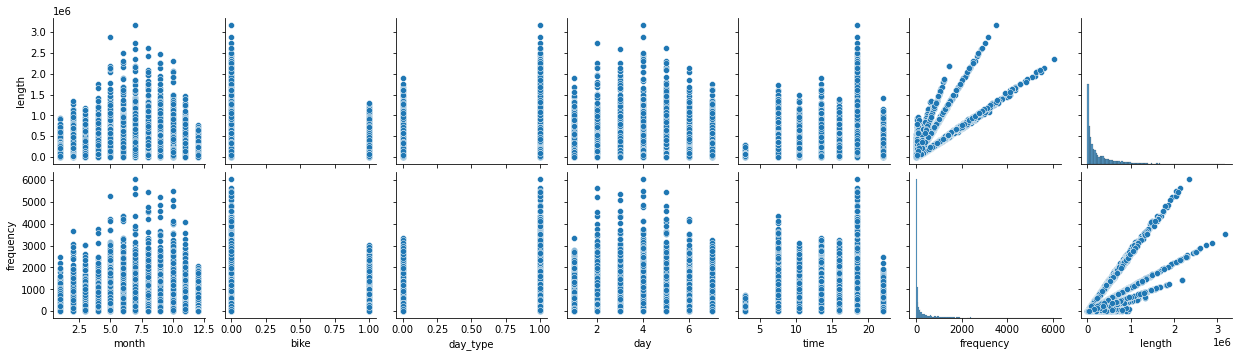

In [15]:
print("Member cyclist plots: ")
sns.pairplot(df2, y_vars = ['length', 'frequency'])

### <u> New Subtopic (Plotting technique) </u>

When we look at the distribution of the frequency and length columns, we notice that it is in a bit of curve, a bit like exponential decay. A method we can use to find some trends, is log scaling. 


We will plot the frequency with log scaling only on the y axis.
This changes the data into the form:

<b>f(x) = a * e^(mx) </b>
where: a is some constant, and m is the slope

We will plot the length with log scaling on both axes.
This changes the data into the form:

<b>f(x) = a * x^(m) </b>
where: a is some constant, and m is the slope

This is useful as it linearizes relationships, and helps find trends better.

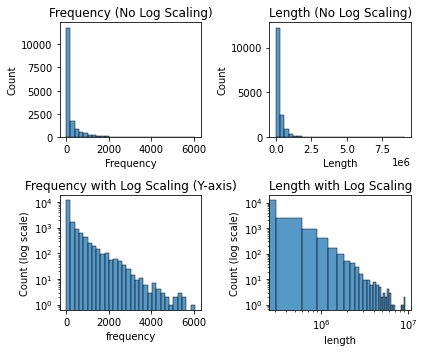

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(6, 5))

# frequency without log scaling
sns.histplot(cyclistdata['frequency'], bins=30, ax=axs[0, 0])
axs[0, 0].set_title("Frequency (No Log Scaling)")
axs[0, 0].set_xlabel("Frequency")
axs[0, 0].set_ylabel("Count")

# length without log scaling
sns.histplot(cyclistdata['length'], bins=30, ax=axs[0, 1])
axs[0, 1].set_title("Length (No Log Scaling)")
axs[0, 1].set_xlabel("Length")

# frequency with log scaling only on y-axis
sns.histplot(cyclistdata['frequency'], bins=30, ax=axs[1, 0])
axs[1, 0].set_yscale("log")
axs[1, 0].set_title("Frequency with Log Scaling (Y-axis)")
axs[1, 0].set_ylabel("Count (log scale)")

# length with log scaling
sns.histplot(cyclistdata['length'], bins=30, ax=axs[1, 1])
axs[1, 1].set_yscale("log")
axs[1, 1].set_xscale("log")
axs[1, 1].set_title("Length with Log Scaling")
axs[1, 1].set_ylabel("Count (log scale)")

plt.tight_layout()
plt.show()


After log scaling, it is visible that the distribution of frequency is exponential. We can find the m value (slope) of the graphs, to find at what rate they are decreasing. 

We can also observe that the lenght distribution is a power law relationship. We can make these oberservations, because the graphs using log are approximately linear.

To find the m value here, we can use sklearn and linear regression. This shows us the rate of change of the two values:

In [17]:
from sklearn.linear_model import LinearRegression
cyclistdata['log_frequency'] = np.log(cyclistdata['frequency']) #add a column for log frequency (we will remove this later)

# Frequency 
frequency_data = cyclistdata['frequency']
count, bins = np.histogram(frequency_data, bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Apply log transformation to y-values
log_count = np.log(count[count > 0])  
log_bin_centers = bin_centers[count > 0] 

# Fit a linear regression
reg = LinearRegression().fit(log_bin_centers.reshape(-1, 1), log_count)
m_frequency = reg.coef_[0] 

# Length
length_data = cyclistdata['length']
count_length, bins_length = np.histogram(length_data, bins=30)
bin_centers_length = (bins_length[:-1] + bins_length[1:]) / 2

# Apply log transformation to both x and y values
log_count_length = np.log(count_length[count_length > 0])
log_bin_centers_length = np.log(bin_centers_length[count_length > 0])

# Fit a linear regression
reg_length = LinearRegression().fit(log_bin_centers_length.reshape(-1, 1), log_count_length)
m_length = reg_length.coef_[0]

print(f"m value for frequency (log y-axis): {m_frequency}")
print(f"m value for length (log-log scaling): {m_length}")


m value for frequency (log y-axis): -0.001368588299918243
m value for length (log-log scaling): -2.5817783098915013


/Users/sophia/miniforge3/envs/jupyter/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
#drop column that was added, as it isn't needed anymore

cyclistdata = cyclistdata.drop(columns=['log_frequency'])

## Models

### Data prep (test and train set)

Now that we are finally ready to move onto training models, we first split the data into a training set and testing set. We do this by randomly picking 20% of the data out.

While there are various ways to split train and test sets, in this case it must be randomly chosen, as the data seems to be sorted, and choosing something like the last # values would not be accurate.

First, we will split the data into X and y, where X is the features, and y is the target.

In [19]:
y = cyclistdata.membership 
X = cyclistdata.drop(columns=['membership'])
print(y.shape)
print(X.shape)
X.head()

(16464,)
(16464, 7)


,month,bike,day_type,day,time,frequency,length
0,9,0,0,1,16.0,490,3964821
1,9,1,0,1,13.5,156,332731
2,9,0,0,1,13.5,831,5495312
3,9,1,0,1,13.5,75,251960
4,9,1,0,1,10.5,139,301329


Next, we split the data into a training and testing set. (80% training, 20% testing)

<u>New subtopic (parameter): random_state</u>
The random state parameter on the train_test_split function is used to set a seed for the random number generator. This is useful as it allows us to reproduce the same results, and is useful for debugging.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11) #I am setting a random state, such that the k value in k Nearest neighbors model makes the most sense. I noticed that each time I ran the code the k value would change drastically.
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13171, 7) (3293, 7) (13171,) (3293,)


### Decision tree

First, we will train it on a basic decision tree. The decision tree is a simple model that can be used for classification. It works by splitting the data into different branches, based on the features, and then predicting the target based on the majority of the target values in the leaf node.

In [21]:
#import necessary modules
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

We will first use the decision tree classifier, and train it on the training set.

In [22]:
classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)

Next, we train. There are various ways to evaluate the predictions. We will use accuracy, as it is the most common metric for classification models. F1 score is also used, as it is the harmonic mean of precision and recall. We will also use a confusion matrix, to see how many false positives and negatives there are.

In [23]:
y_pred = classifier.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
print("\nConfusion Matrix: ")
labels = np.unique(y_test) 
conmatrx = metrics.confusion_matrix(y_test, y_pred, labels=labels)
print(conmatrx)

Accuracy score:  0.691163073185545
F1 Score:  0.6911616491534746

Confusion Matrix: 
[[1143  506]
 [ 511 1133]]


We can see that both the accuracy, f1 score are very low. This indicates a highly innacurate model. Furthermore, the confusion matrix shows that there are many false positives and negatives. There was a total of 1027(511+516) innacurate results, which is unideal.

### K Nearest neighbor

The next model we test is the K Nearst Neighbor model. This model is based on the idea that similar things are close to each other, and therefore it classifies based on the nearest neighbors.

In [24]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier = classifier.fit(X_train, y_train)

After we have trained the model on the training set, we can evaluate it.

In [25]:
y_pred = classifier.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
print("\nConfusion Matrix: ")
labels = np.unique(y_test) 
conmatrx = metrics.confusion_matrix(y_test, y_pred, labels=labels)
print(conmatrx)

Accuracy score:  0.5268751897965381
F1 Score:  0.5268533731850671

Confusion Matrix: 
[[880 769]
 [789 855]]


The accuracy is very low, with 1558 innacurate results. however, in K Nearest neighbors we can change the number of neighbors, and see if that improves the model. We plot the accuracy vs number of neighbors, to choose a good n value.

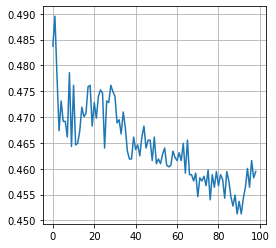

In [26]:
errors = []
for i in np.arange(1, 100):
    c = KNeighborsClassifier(n_neighbors = i)
    c.fit(X_train, y_train)
    y_pred = c.predict(X_test)
    errors.append(np.mean(y_pred != y_test))

plt.figure(figsize=(4,4))
plt.grid()
plt.plot(errors)

We see in the plot above that a n value of 85 is the most ideal, and increases accuracy the most. 

In [27]:
classifier = KNeighborsClassifier(n_neighbors=85)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
print("\nConfusion Matrix: ")
labels = np.unique(y_test) 
conmatrx = metrics.confusion_matrix(y_test, y_pred, labels=labels)
print(conmatrx)

Accuracy score:  0.5405405405405406
F1 Score:  0.5405330831539654

Confusion Matrix: 
[[898 751]
 [762 882]]


While the accuracy did increase compared to no adjustments, and has 45 less innacurate results, it is still very bad. It is clear that K Nearest Neighbors is not the best model for this data. On top of this, the classification is binary, so just barely above 50% accuracy is no good, as it is not much better than random guessing.

### Naive Bayes

The last classification algorithm we learned, and the last one we will be testing is Naive Bayes. Naive Bayes is based on the Bayes theorem, and is a probabilistic model. It is based on the idea that the features are independent of each other. This may be useful, as it appreared that most features on the pairplot were not correlated.

In [28]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model = model.fit(X_train, y_train)

After training the model, we can evaluate it.

In [29]:
y_pred = model.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
print("\nConfusion Matrix: ")
labels = np.unique(y_test) 
conmatrx = metrics.confusion_matrix(y_test, y_pred, labels=labels)
print(conmatrx)

Accuracy score:  0.5453993319161858
F1 Score:  0.4854766614067638

Confusion Matrix: 
[[1461  188]
 [1309  335]]


Once again, the accuracy is very low. It is clear that Naive Bayes is not the best model for this data. Rather, it is the worse out of the 3. Looking at the confusion matrix, we can see that it makes little mistakes when predicting casual riders, but makes many mistakes when predicting member riders. We can see that the model just guesses most people are casual riders, and this is why the accuracy is so low.

# <u>Conclusion</u>

The objective of this project was to analyze riding patterns of bike-share users and train a classification model that can predict whether a cyclist is a member or casual rider, based on their ride statistics from the data. To do this, I used member and casual biker data from a dataset on Kaggle, originally from a bike-share company called Divvy.

When we used pairplots to graph the data, we found that people ride more frequently in the summer, and for longer periods on weekends. We also found that people ride more frequently near 8am and pm, most likely for commuting to work. 

When we used log scaling to find trends, we found that the distribution of frequency is exponential, and the length distribution is a power law relationship. We concluded this becasue when it was graphed using log-log/log scaling on y-axis, the graph was linear.

Unlike when  we tested models in class, the models we tested on this data did not perform well. The accuracy was very low, and the confusion matrix showed that there were many false positives and negatives. This indicates that the models were not able to predict the target accurately. Overall, the decision tree did the best, but it was still not accurate, with only an accuracy of around 68%. This is nothing near usable for the real world, and would need to be improved upon with more data. However, another conclusion that can be drawn from this is that casual riders and members are very similar, and it is hard to predict which one a rider is based on the data.

The K Nearest Neighbor model was the second most accurate, but it was still not accurate. The Naive Bayes model was the least accurate.

## <u>Future Work</u>
To further this project, I would like to look at the correlation of the various features, and create a new model based on the most correlated features. 

Correlation represents the strength and direction of a linear relationship between two variables. It can be easily figured out using the .corr() function. 

In [30]:
corrcyclistdata = cyclistdata.copy()
corrcyclistdata['membership'] = cyclistdata['membership'].map({'casual': 0, 'member': 1}) #map the membership column to 0 and 1, to be able to plot it
corrcyclistdata.corr()

,month,bike,day_type,day,time,frequency,length,membership
month,1.000000e+00,-4.613995e-18,-6.006064e-16,-8.287807e-17,-1.493289e-18,0.074891,0.076650,9.418262e-17
bike,-4.613995e-18,1.000000e+00,-7.307852e-18,5.745121e-16,2.308151e-18,-0.166093,-0.280029,2.718860e-15
day_type,-6.006064e-16,-7.307852e-18,1.000000e+00,1.768338e-15,1.205271e-15,0.000304,-0.083164,4.979993e-16
day,-8.287807e-17,5.745121e-16,1.768338e-15,1.000000e+00,1.297988e-15,0.023593,0.034383,7.274496e-15
time,-1.493289e-18,2.308151e-18,1.205271e-15,1.297988e-15,1.000000e+00,0.128480,0.157478,2.999857e-15
frequency,7.489102e-02,-1.660929e-01,3.044599e-04,2.359309e-02,1.284799e-01,1.000000,0.548617,1.458580e-01
length,7.665042e-02,-2.800293e-01,-8.316447e-02,3.438305e-02,1.574782e-01,0.548617,1.000000,-2.040933e-02
membership,9.418262e-17,2.718860e-15,4.979993e-16,7.274496e-15,2.999857e-15,0.145858,-0.020409,1.000000e+00


Now, it is very difficult to understand what this graph means. However, we can use a heatmap to easily visualize the correlation between the features. This can help us quickly evaluate which features are most important, and which are not.

A heatmap is a graphical representation of data where the individual values contained in a matrix are represented as colors. The lighter the color, the higher the correlation.

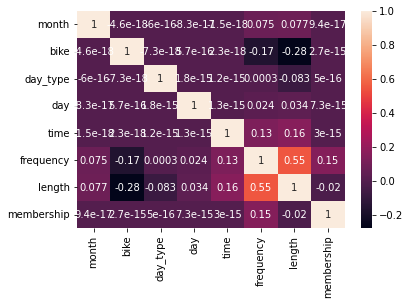

In [31]:
correlation_matrix = corrcyclistdata.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

From this heatmap, it is clear that the most important features are frequency, length, time and month. This is useful, as it can help us decide which features to use in the model. Lets try making a model once more, but only using these features.


### New Model (updated features)

First, lets drop all the features that are not important, and only keep the ones that are.

In [32]:
newdf = cyclistdata.drop(['bike', 'day','day_type'], axis=1)

Then, we split the data into a training and testing set, and train the model using a decision tree. I am using a decision tree, as it is the most accurate model so far.

In [33]:
y = newdf.membership 
X = newdf.drop(columns=['membership'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11)
classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)

Testing the model, to see if the accuracy has improved.

In [34]:
y_pred = classifier.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
print("\nConfusion Matrix: ")
labels = np.unique(y_test) 
conmatrx = metrics.confusion_matrix(y_test, y_pred, labels=labels)
print(conmatrx)

Accuracy score:  0.6501670209535378
F1 Score:  0.6501584392524813

Confusion Matrix: 
[[1080  569]
 [ 583 1061]]


Unfortunately, the accuracy has actually gone down. This indicates that the features that were dropped were actually important, and that updating the model may be more difficult than expected. This could indicate that differnet models might be better for this data.

All in all, it is very hard to classify between casual and member users, as they are very similar. This could be due to the fact that the data is very preprocessed, or because there simply is no strong correlation between the features and the target. Nonetheless, there are some visible trends between casual and members, expecially in length, frequency, and when they go on rides.